In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from Utilities import PlotImages

In [2]:
def buildCustomModel(input_shape, output, convolutionalRegions=5, layersInRegion=3):
    model = Sequential()
    
    model.add(Conv2D(10,3,
                     padding='same', 
                     input_shape=input_shape,
                     activation='relu'))
    
    for regionNum in range(convolutionalRegions):
        for layerNum in range(layersInRegion):
            model.add(Conv2D((2**(regionNum+1))*10,3,
                     padding='same',
                     activation='relu'))
        model.add(Dropout(.15))
        model.add(MaxPooling2D(pool_size=(2,2),
                     strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(output,
                     activation='softmax'))
    return model

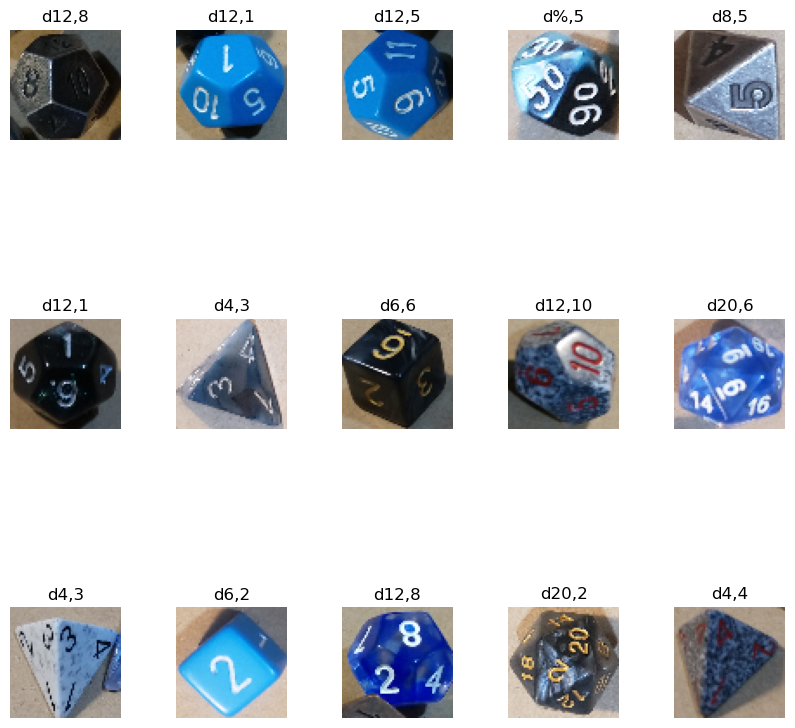

In [3]:
data = np.load("/work/MA490_DeepLearning/Share/Dice/RotatedDiceImages64pix.npz", allow_pickle=True)
images = data["images"]
labels = data["labels"]
# images[500:,:] = images[500:,:] / 255
PlotImages(499, 15, 3, 5, images, labels)
plt.show()

In [4]:
typeOfDice = 6
d6images = []
d6labels = []
for i in range(len(images)):
    split = labels[i].split(",")
    if len(split) != 2:
        continue
    (diceType, diceValue) = split
    if diceType == "d"+str(typeOfDice) and diceValue.isnumeric() and int(diceValue) < typeOfDice+1:
        d6images.append(images[i])
        d6labels.append(diceValue)
        
d6images = np.array(d6images)
d6labels = np.array(d6labels)

In [5]:
numTest = 40
d6imagesTest = d6images[:numTest]
d6labelsTest = d6labels[:numTest]
d6images = d6images[numTest:]
d6labels = d6labels[numTest:]

In [6]:
print(d6images.shape)
print(type(d6labels[0]))
X = d6images
y = np.array(list(map(lambda x: float(x) - 1, d6labels)))
# X = images
# y = np.array(list(map(lambda x: float(x) - 1, labels)))
# y = to_categorical(y)

(2128, 64, 64, 3)
<class 'numpy.str_'>


In [7]:
y.shape

(2128,)

In [8]:
###################
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
###################

In [9]:
customModel = buildCustomModel((64,64,3), 6, 5, 1)

customModel.compile(loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy'])

In [10]:
customModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 10)        280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 40)        7240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 40)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 40)        0

In [11]:
with tf.device('/device:GPU:5'):
    hist = customModel.fit(X,y,
            epochs=50,
            validation_split=0.2,
            verbose=2)

Epoch 1/50
54/54 - 91s - loss: 1.7907 - accuracy: 0.1716 - val_loss: 1.7844 - val_accuracy: 0.1948
Epoch 2/50
54/54 - 1s - loss: 1.7864 - accuracy: 0.1780 - val_loss: 1.7823 - val_accuracy: 0.2512
Epoch 3/50
54/54 - 0s - loss: 1.7830 - accuracy: 0.1804 - val_loss: 1.7713 - val_accuracy: 0.2465
Epoch 4/50
54/54 - 0s - loss: 1.7813 - accuracy: 0.1933 - val_loss: 1.7710 - val_accuracy: 0.2465
Epoch 5/50
54/54 - 0s - loss: 1.7808 - accuracy: 0.2180 - val_loss: 1.7739 - val_accuracy: 0.1901
Epoch 6/50
54/54 - 0s - loss: 1.7288 - accuracy: 0.2568 - val_loss: 1.7322 - val_accuracy: 0.2958
Epoch 7/50
54/54 - 0s - loss: 1.6634 - accuracy: 0.2961 - val_loss: 1.6328 - val_accuracy: 0.3239
Epoch 8/50
54/54 - 0s - loss: 1.5682 - accuracy: 0.3367 - val_loss: 1.6075 - val_accuracy: 0.3638
Epoch 9/50
54/54 - 0s - loss: 1.4503 - accuracy: 0.3784 - val_loss: 1.4352 - val_accuracy: 0.4131
Epoch 10/50
54/54 - 0s - loss: 1.2872 - accuracy: 0.4642 - val_loss: 1.3513 - val_accuracy: 0.4577
Epoch 11/50
54/54 